In [1]:
import os
import numpy as np
from PIL import Image
import pybullet as p
import pybullet_data

OBJS_DIR = os.path.join('core', 'sim', 'objects')

Loading specific rearrangement: rearrangement_00960
Loading specific rearrangement: rearrangement_00960
Scene ID: 960
Number of objects: 6
Grid size: [100, 100]
Loading specific rearrangement: rearrangement_00960


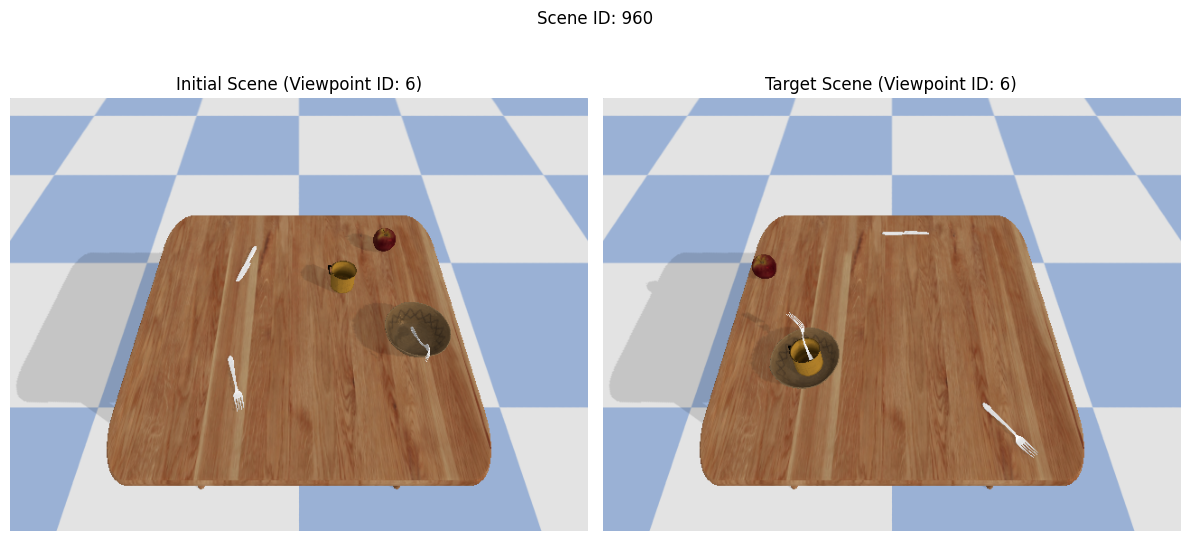

In [9]:
from core.env.scene_manager import SceneManager
from core.env.scene_utils import scene_meta_to_x
from core.sim.rearrangemet_loader import select_rearrangement_dir, load_rearrangement_meta, visualize_rearrangement

dataset_dir = "dataset-sim"
folder_path, scene_id = select_rearrangement_dir(dataset_dir, scene_id=960)
meta_data = load_rearrangement_meta(dataset_dir, scene_id=scene_id)

print(f"Scene ID: {meta_data.get('scene_id', 'Unknown')}")
print(f"Number of objects: {meta_data.get('num_objects', 'Unknown')}")
print(f"Grid size: {meta_data.get('grid_size', 'Unknown')}")

initial_x, target_x = scene_meta_to_x(meta_data)
env = SceneManager(
    num_objects=meta_data['num_objects'],
    grid_size=tuple(meta_data['grid_size']),
    verbose=0,
)
env.reset(initial_scene=initial_x, target_scene=target_x)
# env.render(fig_size=3)
visualize_rearrangement(dataset_dir, scene_id=scene_id)

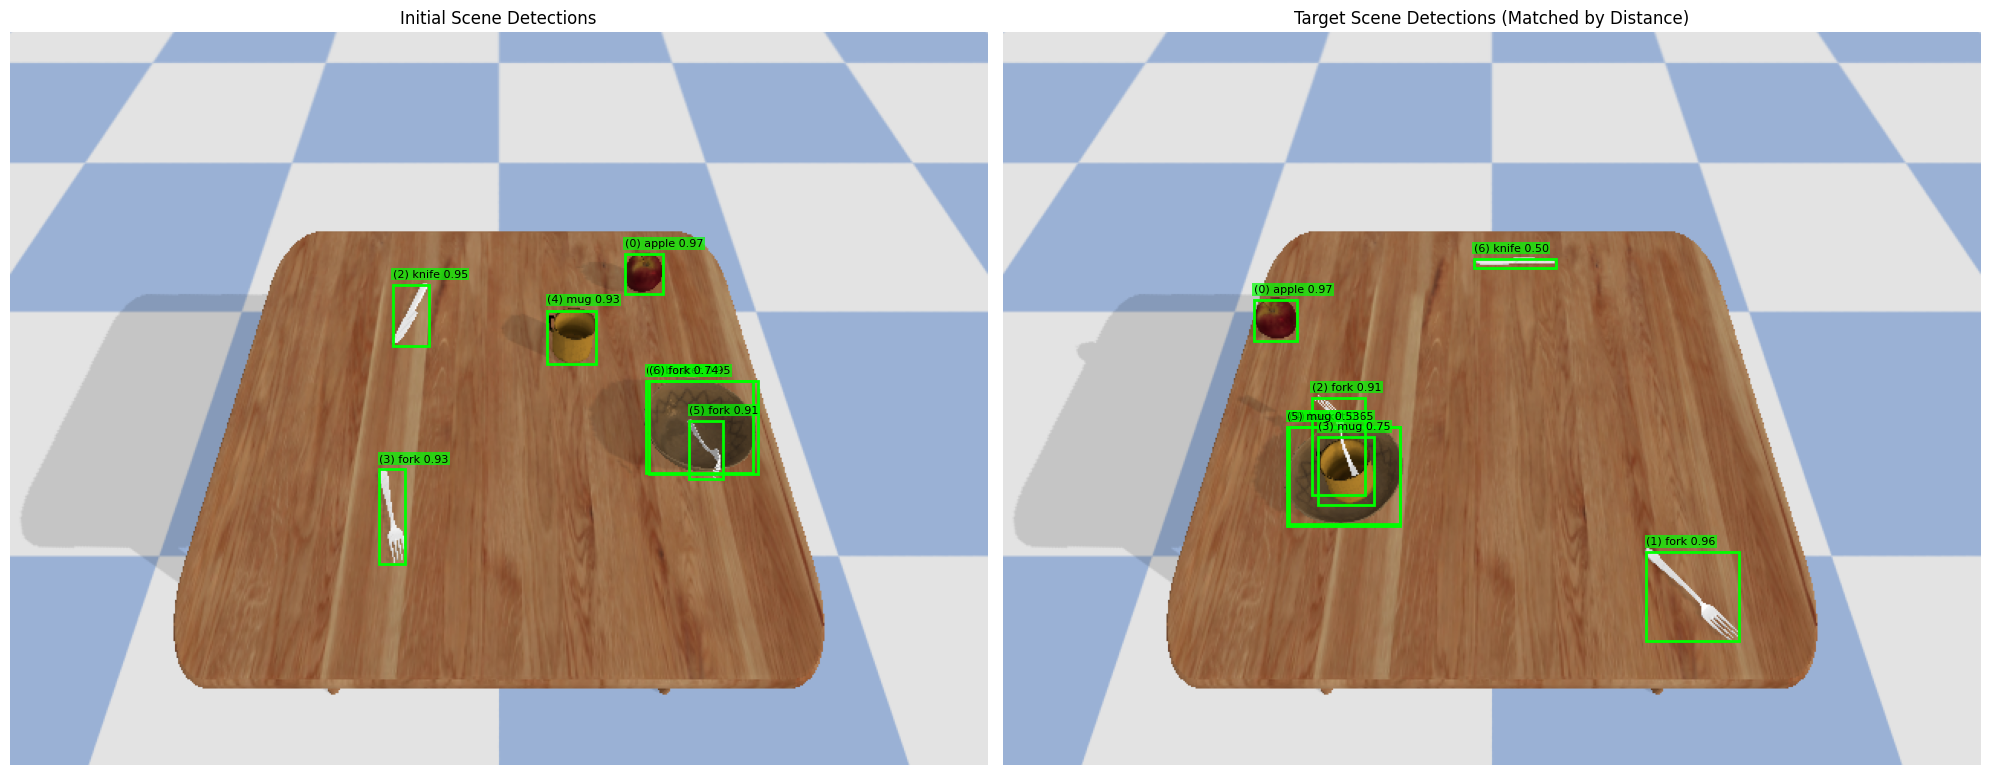


Sorted initial detections:
Obj ID 0: {'bbox': [250, 165, 274, 205], 'confidence': 0.9543401002883911, 'class': 7}
Obj ID 1: {'bbox': [444, 254, 466, 292], 'confidence': 0.9090482592582703, 'class': 11}
Obj ID 2: {'bbox': [416, 228, 486, 288], 'confidence': 0.9546217918395996, 'class': 0}
Obj ID 3: {'bbox': [351, 182, 383, 217], 'confidence': 0.9293226599693298, 'class': 1}
Obj ID 4: {'bbox': [402, 145, 427, 171], 'confidence': 0.9668065905570984, 'class': 9}
Obj ID 5: {'bbox': [241, 286, 258, 348], 'confidence': 0.9310231804847717, 'class': 11}

--- Matching by BBox Distance ---
Sorted target detections (matched by distance):
Obj ID 0: {'bbox': [308, 148, 362, 154], 'confidence': 0.4951718747615814, 'class': 7}
Obj ID 1: {'bbox': [421, 340, 482, 398], 'confidence': 0.9583788514137268, 'class': 11}
Obj ID 2: {'bbox': [187, 258, 260, 322], 'confidence': 0.647455096244812, 'class': 0}
Obj ID 3: {'bbox': [206, 265, 243, 309], 'confidence': 0.7504404187202454, 'class': 1}
Obj ID 4: {'bbox'

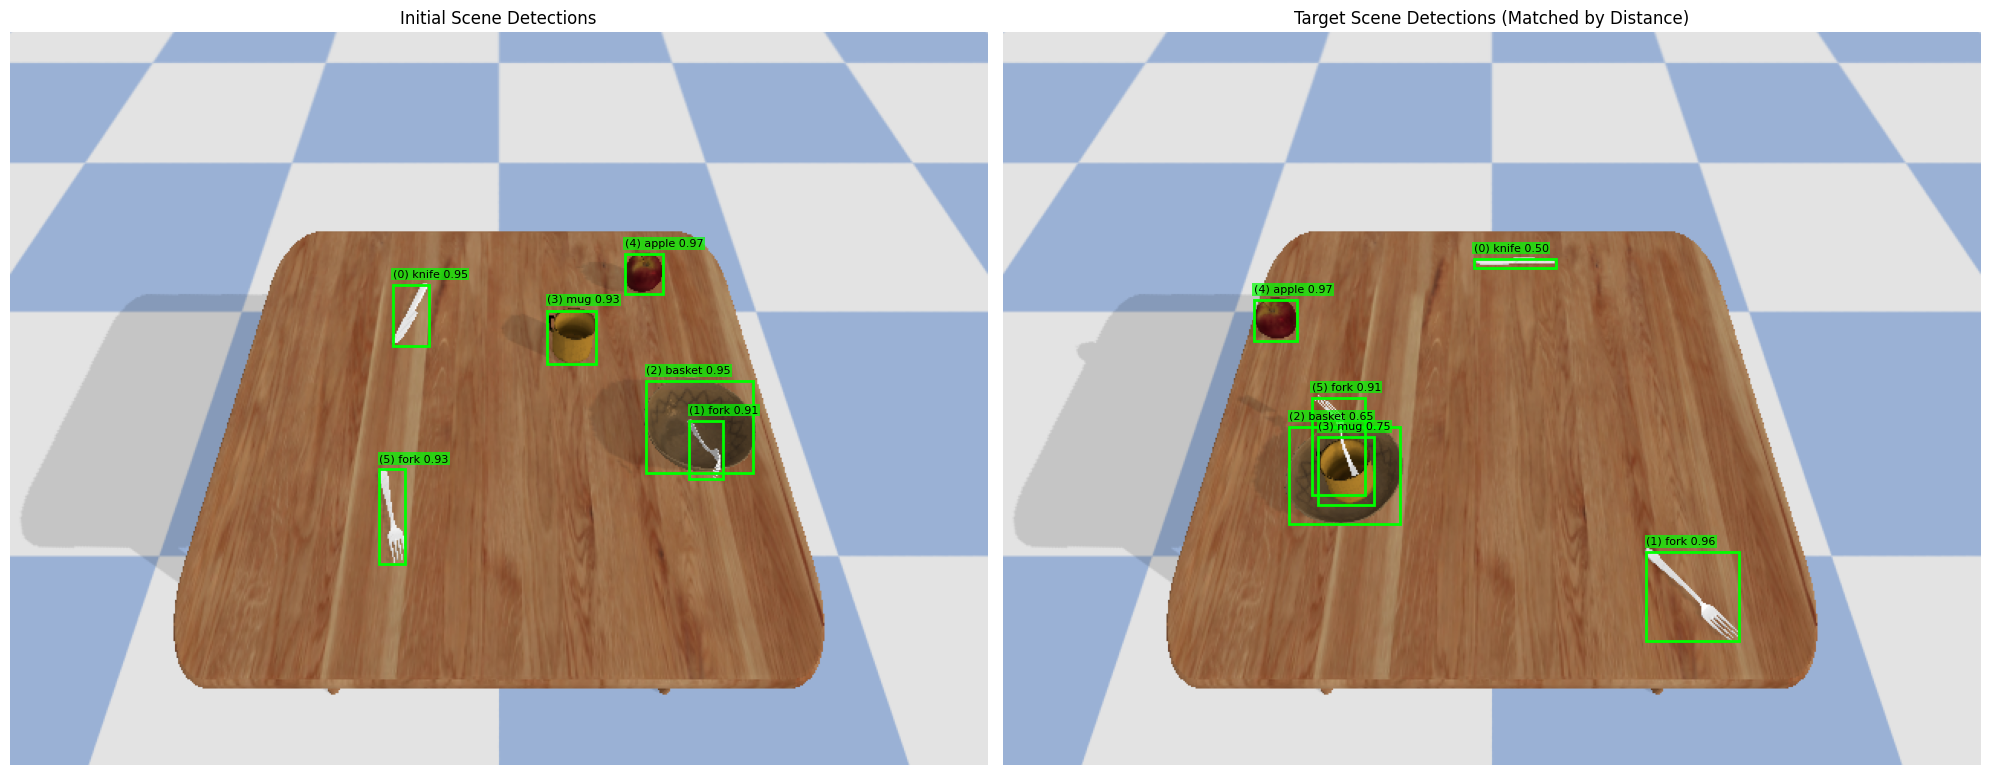

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from collections import Counter, defaultdict
import numpy as np
import random
try:
	from scipy.optimize import linear_sum_assignment
except ImportError:
	raise ImportError("scipy is required for distance-based matching. Please install it using 'pip install scipy'")


def cal_iou(b1, b2):
	"""Calculates IoU for boxes in [xmin, ymin, xmax, ymax] format."""
	# Determine the coordinates of the intersection rectangle
	inter_x1 = max(b1[0], b2[0])
	inter_y1 = max(b1[1], b2[1])
	inter_x2 = min(b1[2], b2[2])
	inter_y2 = min(b1[3], b2[3])

	# Compute the area of intersection
	inter_w = max(0, inter_x2 - inter_x1)
	inter_h = max(0, inter_y2 - inter_y1)
	inter_area = inter_w * inter_h

	# Compute the area of both bounding boxes
	area1 = (b1[2] - b1[0]) * (b1[3] - b1[1])
	area2 = (b2[2] - b2[0]) * (b2[3] - b2[1])

	# Compute the area of union
	union_area = area1 + area2 - inter_area
	return inter_area / union_area if union_area > 0 else 0.0

def plot_detections(image, detections, class_map=None, ax=None, title=None):
	"""
	Plots an image and overlays bounding boxes from detections on a given ax.

	If no ax is provided, a new figure and axes will be created.

	Args:
		image (PIL.Image.Image or str): The image to display or path to it.
		detections (list): A list of detected objects. Each detection is a
						dict with 'bbox', 'confidence', and 'class'.
		class_map (dict, optional): A map from class ID to class name.
									If provided, labels will be displayed.
		ax (matplotlib.axes.Axes, optional): The axes to plot on.
		title (str, optional): The title for the subplot.
	"""
	if isinstance(image, str):
		try:
			image = Image.open(image)
		except FileNotFoundError:
			print(f"Error: Image file not found at {image}")
			return

	# If no axes is provided, create a new figure and axes
	show_plot = False
	if ax is None:
		fig, ax = plt.subplots(1, figsize=(12, 9))
		show_plot = True

	ax.imshow(image)

	# Create a reverse map from class ID to name for labeling
	id_to_name = {v: k for k, v in class_map.items()} if class_map else None

	for i, det in enumerate(detections):
		bbox = det['bbox']
		xmin, ymin, xmax, ymax = bbox
		width = xmax - xmin
		height = ymax - ymin

		# Create a Rectangle patch
		rect = patches.Rectangle(
			(xmin, ymin), width, height,
			linewidth=2, edgecolor='lime', facecolor='none'
		)
		ax.add_patch(rect)

		# Add a label
		label_parts = []
		if id_to_name:
			label_parts.append(f"({i})")
			label_parts.append(id_to_name.get(det['class'], f"ID {det['class']}"))
		if 'confidence' in det:
			label_parts.append(f"{det['confidence']:.2f}")
		
		if label_parts:
			ax.text(
				xmin, ymin - 5, " ".join(label_parts),
				color='black', fontsize=8,
				bbox=dict(facecolor='lime', alpha=0.7, pad=1, edgecolor='none')
			)

	ax.axis('off')
	if title:
		ax.set_title(title)
	
	# Only call plt.show() if we created the figure inside this function
	if show_plot:
		plt.tight_layout()
		plt.show()

def filter_duplicate_detections(
	detections, 
	same_class_iou_thres=0.65, 
	cross_class_iou_thres=0.90
):
	"""
	Filters out duplicate detections using Non-Maximum Suppression (NMS).

	This function handles both same-class and cross-class duplicates. It keeps
	the detection with the highest confidence and removes others that have a
	high overlap (IoU).

	Args:
		detections (list): A list of detected objects from YOLO.
						Each detection is a dict with 'bbox', 'confidence', and 'class'.
		same_class_iou_thres (float): The IoU threshold for detections of the same class.
		cross_class_iou_thres (float): The IoU threshold for detections of different classes.
									This should be high to only remove clear duplicates.

	Returns:
		list: A new list of filtered detections.
	"""
	# Sort detections by confidence in descending order
	dets = sorted(detections, key=lambda d: d["confidence"], reverse=True)
	
	kept_detections = []
	while dets:
		# Keep the detection with the highest confidence
		best_det = dets.pop(0)
		kept_detections.append(best_det)
		
		# Remove other detections that have a high IoU
		remaining_dets = []
		for d in dets:
			iou = cal_iou(best_det['bbox'], d['bbox'])

			# Check for same-class duplicates
			if d['class'] == best_det['class']:
				if iou <= same_class_iou_thres:
					remaining_dets.append(d)
			# Check for cross-class duplicates (high overlap but different class)
			else:
				if iou <= cross_class_iou_thres:
					remaining_dets.append(d)
		dets = remaining_dets
		
	return kept_detections

def sort_and_validate_detections(label_file_path, det, class_map, iou_threshold=0.5):
	"""
	Sorts and validates detected objects against a ground-truth label file.

	Args:
		label_file_path (str): Path to the JSON label file.
		det (list): A list of detected objects from YOLO.
		class_map (dict): A dictionary mapping model names to class IDs.
		iou_threshold (float): The minimum IoU for a bbox to be considered a match.

	Returns:
		list: A new list of detections sorted according to the obj_id in the label file.

	Raises:
		ValueError: If there is a mismatch in object counts or if a match isn't found.
	"""

	with open(label_file_path, 'r') as f:
		labels = json.load(f)
	
	gt_objects = sorted(labels['objects'], key=lambda x: x['obj_id'])

	if len(det) != len(gt_objects):
		raise ValueError(f"Mismatch in object count. Expected {len(gt_objects)}, but detected {len(det)}.")

	sorted_det = [None] * len(gt_objects)
	unmatched_det_indices = set(range(len(det)))

	for gt_obj in gt_objects:
		gt_class_id = class_map.get(gt_obj['model_name'])
		if gt_class_id is None:
			raise ValueError(f"Model name '{gt_obj['model_name']}' not in class_map.")
		
		best_match_idx = -1
		best_iou = -1

		for i in unmatched_det_indices:
			detected_obj = det[i]
			if detected_obj['class'] == gt_class_id:
				iou = cal_iou(gt_obj['bbox'], detected_obj['bbox'])
				if iou > best_iou:
					best_iou = iou
					best_match_idx = i
		
		if best_match_idx != -1 and best_iou >= iou_threshold:
			sorted_det[gt_obj['obj_id']] = det[best_match_idx]
			unmatched_det_indices.remove(best_match_idx)
		else:
			raise ValueError(f"No valid match found for ground-truth object ID {gt_obj['obj_id']} ('{gt_obj['model_name']}'). Best IoU was {best_iou:.2f}.")

	return sorted_det

def match_target_detections_randomly(initial_sorted_dets, target_dets):
	"""
	Matches detections from a target scene to a sorted list of initial detections.

	This function separates matching for unique objects and objects with multiple
	instances of the same class.

	Args:
		initial_sorted_dets (list): A list of sorted detections from the initial scene.
		target_dets (list): A list of filtered detections from the target scene.

	Returns:
		list: A new list of target detections sorted to match the initial detections.

	Raises:
		ValueError: If the object classes in the target scene do not match the initial scene.
	"""
	# Validate that the same set of objects exists in both scenes
	initial_classes = Counter(d['class'] for d in initial_sorted_dets)
	target_classes = Counter(d['class'] for d in target_dets)

	if initial_classes != target_classes:
		raise ValueError(f"Object mismatch between scenes. Initial: {initial_classes}, Target: {target_classes}")

	# --- Setup ---
	sorted_target_list = [None] * len(initial_sorted_dets)
	
	# Group target detections by class
	unmatched_target_by_class = defaultdict(list)
	for det in target_dets:
		unmatched_target_by_class[det['class']].append(det)

	# For classes with multiple instances, shuffle the list to ensure random assignment
	for class_list in unmatched_target_by_class.values():
		random.shuffle(class_list)

	# --- Match objects ---
	# Iterate through the sorted initial objects and find matches
	for i, initial_det in enumerate(initial_sorted_dets):
		initial_class = initial_det['class']
		
		# Check if there is a corresponding target object
		if not unmatched_target_by_class[initial_class]:
			raise RuntimeError(f"Logic error: No available target object for class {initial_class}")
		
		# Pop a target detection of the same class and assign it
		# For classes with multiple objects, this is a random (first-in, first-out) assignment
		matched_det = unmatched_target_by_class[initial_class].pop()
		sorted_target_list[i] = matched_det

	return sorted_target_list

def match_target_detections_by_distance(initial_sorted_dets, target_dets):
	"""
	Matches target detections to initial detections by minimizing bbox center distance.

	For classes with a single instance, it performs a direct match. For classes
	with multiple instances, it uses the Hungarian algorithm to find the optimal
	assignment that minimizes the sum of Euclidean distances between the centers
	of the bounding boxes.

	Args:
		initial_sorted_dets (list): A list of sorted detections from the initial scene.
		target_dets (list): A list of filtered detections from the target scene.

	Returns:
		list: A new list of target detections sorted to match the initial detections.

	Raises:
		ValueError: If the object classes in the target scene do not match the initial scene.
	"""
	# --- Validation ---
	initial_classes = Counter(d['class'] for d in initial_sorted_dets)
	target_classes = Counter(d['class'] for d in target_dets)
	if initial_classes != target_classes:
		raise ValueError(f"Object mismatch. Initial: {initial_classes}, Target: {target_classes}")

	# --- Helper Functions ---
	def get_bbox_center(det):
		box = det['bbox']
		return np.array([(box[0] + box[2]) / 2, (box[1] + box[3]) / 2])

	# --- Setup ---
	sorted_target_list = [None] * len(initial_sorted_dets)
	
	# Group initial and target detections by class
	initial_by_class = defaultdict(list)
	for i, det in enumerate(initial_sorted_dets):
		initial_by_class[det['class']].append({'idx': i, 'det': det})

	target_by_class = defaultdict(list)
	for det in target_dets:
		target_by_class[det['class']].append(det)

	# --- Match objects ---
	for class_id, initial_dets in initial_by_class.items():
		target_dets_for_class = target_by_class[class_id]

		if len(initial_dets) == 1:
			# Simple case: unique object
			sorted_target_list[initial_dets[0]['idx']] = target_dets_for_class[0]
		else:
			# Complex case: multiple objects of the same class
			# Create a cost matrix of distances
			num_instances = len(initial_dets)
			cost_matrix = np.zeros((num_instances, num_instances))
			
			for i in range(num_instances):
				for j in range(num_instances):
					center_initial = get_bbox_center(initial_dets[i]['det'])
					center_target = get_bbox_center(target_dets_for_class[j])
					cost_matrix[i, j] = np.linalg.norm(center_initial - center_target)
			
			# Find the optimal assignment using the Hungarian algorithm
			row_ind, col_ind = linear_sum_assignment(cost_matrix)
			
			# Assign the matched objects
			for i, j in zip(row_ind, col_ind):
				initial_idx = initial_dets[i]['idx']
				sorted_target_list[initial_idx] = target_dets_for_class[j]

	return sorted_target_list

det = [
	{'bbox': [402, 145, 427, 171], 'confidence': 0.9668065905570984, 'class': 9},
	{'bbox': [416, 228, 486, 288], 'confidence': 0.9546217918395996, 'class': 0},
	{'bbox': [250, 165, 274, 205], 'confidence': 0.9543401002883911, 'class': 7},
	{'bbox': [241, 286, 258, 348], 'confidence': 0.9310231804847717, 'class': 11},
	{'bbox': [351, 182, 383, 217], 'confidence': 0.9293226599693298, 'class': 1},
	{'bbox': [444, 254, 466, 292], 'confidence': 0.9090482592582703, 'class': 11},
	{'bbox': [418, 228, 489, 289], 'confidence': 0.7398642897605896, 'class': 11}
]

det_tgt = [
	{'bbox': [164, 175, 192, 202], 'confidence': 0.9656243920326233, 'class': 9},
	{'bbox': [421, 340, 482, 398], 'confidence': 0.9583788514137268, 'class': 11},
	{'bbox': [202, 239, 237, 303], 'confidence': 0.9138810634613037, 'class': 11},
	{'bbox': [206, 265, 243, 309], 'confidence': 0.7504404187202454, 'class': 1},
	{'bbox': [187, 258, 260, 322], 'confidence': 0.647455096244812, 'class': 0},
	{'bbox': [186, 258, 260, 323], 'confidence': 0.528247058391571, 'class': 1},
	{'bbox': [308, 148, 362, 154], 'confidence': 0.4951718747615814, 'class': 7}
]

# det = [
# 	{'bbox': [399, 255, 464, 298], 'confidence': 0.9695289134979248, 'class': 7},
# 	{'bbox': [205, 145, 295, 246], 'confidence': 0.9546229243278503, 'class': 4},
# 	{'bbox': [123, 253, 153, 281], 'confidence': 0.9497398138046265, 'class': 5},
# 	{'bbox': [259, 153, 287, 226], 'confidence': 0.9344382286071777, 'class': 10},
# 	{'bbox': [390, 122, 510, 205], 'confidence': 0.9342065453529358, 'class': 3},
# 	{'bbox': [430, 125, 493, 187], 'confidence': 0.9133400917053223, 'class': 2},
# 	{'bbox': [208, 145, 296, 244], 'confidence': 0.5676392316818237, 'class': 10},
# 	{'bbox': [398, 123, 510, 203], 'confidence': 0.4619194567203522, 'class': 2}
# ]


# det_tgt = [
# 	{'bbox': [203, 324, 298, 433], 'confidence': 0.960112988948822, 'class': 4},
# 	{'bbox': [290, 55, 359, 84], 'confidence': 0.9527997374534607, 'class': 10},
# 	{'bbox': [350, 135, 471, 218], 'confidence': 0.947045087814331, 'class': 3},
# 	{'bbox': [375, 314, 453, 337], 'confidence': 0.9440873265266418, 'class': 2},
# 	{'bbox': [274, 177, 300, 202], 'confidence': 0.943065345287323, 'class': 5},
# 	{'bbox': [396, 118, 408, 187], 'confidence': 0.9013673663139343, 'class': 7}
# ]

class_map = {'basket': 0, 'mug': 1, 'spoon': 2, 'pot': 3, 'box': 4, 'pear': 5, 'knife': 7, 'apple': 9, 'banana':10, 'fork': 11}

initial_labels = os.path.join(folder_path, 'initial_labels.json')
initial_image_path = os.path.join(folder_path, 'initial_image.png')
target_image_path = os.path.join(folder_path, 'target_image.png')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_detections(initial_image_path, det, class_map, ax=ax1, title="Initial Scene Detections")
plot_detections(target_image_path, det_tgt, class_map, ax=ax2, title="Target Scene Detections (Matched by Distance)")
plt.tight_layout()
plt.show()

# Filter out duplicate detections before matching with ground truth
filtered_det = filter_duplicate_detections(det)

# Sort and validate detections against the ground truth labels
sorted_detections = sort_and_validate_detections(initial_labels, filtered_det, class_map)

print("\nSorted initial detections:")
for i, d in enumerate(sorted_detections):
	print(f"Obj ID {i}: {d}")

# Object Matching
filtered_det_tgt = filter_duplicate_detections(det_tgt)

# --- Match using the new distance-based method ---
print("\n--- Matching by BBox Distance ---")
sorted_det_tgt_dist = match_target_detections_by_distance(sorted_detections, filtered_det_tgt)
print("Sorted target detections (matched by distance):")
for i, d in enumerate(sorted_det_tgt_dist):
	print(f"Obj ID {i}: {d}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plot_detections(initial_image_path, sorted_detections, class_map, ax=ax1, title="Initial Scene Detections")
plot_detections(target_image_path, sorted_det_tgt_dist, class_map, ax=ax2, title="Target Scene Detections (Matched by Distance)")
plt.tight_layout()
plt.show()

# Sim

In [ ]:
from core.sim.physics_utils import PyBulletSim, load_table_urdf, get_object_extents
from core.sim.camera_manager import CameraManager
import matplotlib.pyplot as plt
from core.sim.rearrangemet_loader import generate_scene_objects_from_meta, adjust_objects_for_target_scene

sim = PyBulletSim(p.DIRECT)
grid_size = tuple(meta_data['grid_size'])
table = load_table_urdf(OBJS_DIR, grid_size)
z = get_object_extents(table)[2]
cam = CameraManager()
cam.set_viewpoint(target_pos=[0, 0, z], viewpoint_id=8)

objects = generate_scene_objects_from_meta(
	OBJS_DIR, meta_data, z, grid_size=grid_size,
	target_mode=False,
)

sim.step(1)

fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(9):
    cam.set_viewpoint(target_pos=[0, 0, z], viewpoint_id=i+1)
    ax[i//3, i%3].imshow(cam.capture_image())
    ax[i//3, i%3].set_title(f"Viewpoint {i+1}")
    ax[i//3, i%3].axis('off')
    plt.tight_layout()
plt.show()

# cam.show_img(cam.capture_image())

# objects = adjust_objects_for_target_scene(objects, meta_data, z, grid_size=grid_size)
# for obj in objects:
# 	orn = p.getQuaternionFromEuler(obj['final_orn'])
# 	p.resetBasePositionAndOrientation(obj['body_id'], obj['final_pos'], orn)

sim.step(1)

cam.show_img(cam.capture_image())

sim.close()

# Image to Meta

In [ ]:
from core.env.scene_manager import OBJECTS
from core.sim.rearrangemet_loader import load_scene_objects_from_labels, world_to_grid_coords

sim = PyBulletSim(p.DIRECT)
grid_size = (100, 100)
table = load_table_urdf(OBJS_DIR, grid_size)
z = get_object_extents(table)[2]
cam = CameraManager()
cam.set_viewpoint(target_pos=[0, 0, z], viewpoint_id=8)
objects = load_scene_objects_from_labels(OBJS_DIR, folder_path)
print(objects)
sim.step(2)

bboxes, labels, vis_ratios = [], [], []
for obj in objects:
	bbox, vis_ratio = cam.compute_2d_bounding_box(OBJS_DIR, obj['model_name'], obj['body_id'], obj['body_type'])
	bbox_size = ((bbox[2] - bbox[0]) * (bbox[3] - bbox[1]))
	u, v = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
	obj_pos = cam.project_pixel_to_world(u, v, n=np.array([0, 0, 1]), p0=np.array([0, 0, z+0.05]))
	grid_pos = world_to_grid_coords(obj_pos, grid_size=grid_size)
	label = next((k for k, v in OBJECTS.items() if v['name'] == obj['model_name']), None)
	print(label, grid_pos)

	if bbox is None or vis_ratio < 0.3 or bbox_size < 400:
		print(f"Object {obj['object_id']} ({obj['model_name']}) is not sufficiently visible.")

	bboxes.append(bbox)
	labels.append(f"{obj['model_name']}_{obj['object_id']}")
	vis_ratios.append(vis_ratio)
	print(f"{obj['object_id']} ({obj['model_name']}) - VR: {vis_ratio:.2f} - BB: {bbox_size}")

cam.draw_2d_bounding_boxes(cam.capture_image(), bboxes, labels)

sim.close()

In [ ]:
import pathlib
import torch
pathlib.PosixPath = pathlib.WindowsPath

model_path = f'perception/final_yolov5l/weights/best.pt'
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, force_reload=True, device='cpu')

In [ ]:
img_unseen = Image.open(f"dataset/rearrangement_00001/initial_image.png")
results = model(img_unseen)
# results.pandas().xyxy
results.show()

# Tilt

In [ ]:
from core.sim.physics_utils import PyBulletSim, load_object_urdf, get_object_extents, apply_random_tilt

sim = PyBulletSim(p.GUI)
# sim = PyBulletSim(p.DIRECT)
cam = CameraManager(target_pos=[0.5, 0, 1], distance=0.1, yaw=90, pitch=-40, roll=0)
table = load_table_urdf(OBJS_DIR, (100, 100))
z = get_object_extents(table)[2]
print(get_object_extents(table))
load_object_urdf(OBJS_DIR, 'basket', [0.3, -0.15, z+0.05], body_type=3, use_fixed_base=True)
# mug_orn = [0, 0, random.uniform(0, 2 * np.pi)]
mug_orn = [0, 0, np.pi/1.5]
load_object_urdf(OBJS_DIR, 'mug',    [0.3, -0.15, z+0.1], mug_orn, body_type=3)
pos, orn = [0.3, -0.15, z+0.2], [np.pi / 2, 0, 0]
pos, orn = apply_random_tilt(pos, orn, max_shift=0.01, tilt_angle=10)
load_object_urdf(OBJS_DIR, 'spoon',  pos, orn)

# sim.step(20)
load_object_urdf(OBJS_DIR, 'mug',    [0.3, 0.15, z+0.08], mug_orn, body_type=3)
load_object_urdf(OBJS_DIR, 'spoon',  pos+[0, 0.3, 0], orn)

sim.run()
sim.close()